# Quantization Aware Training with NNCF, using TensorFlow Framework

The goal of this notebook to demonstrate how to use the Neural Network Compression Framework [NNCF](https://github.com/openvinotoolkit/nncf) 8-bit quantization to optimize a TensorFlow model for inference with OpenVINO Toolkit. The optimization process contains the following steps:
* Transform the original FP32 model to INT8
* Use fine-tuning to restore the accuracy
* Export optimized and original models to Frozen Graph and then to OpenVINO
* Measure and compare the performance of models

For more advanced usage, please refer to these [examples](https://github.com/openvinotoolkit/nncf/tree/develop/examples).

We selected the ResNet-18 model with Imagenette dataset. Imagenette is a subset of 10 easily classified classes from the Imagenet dataset. Using the smaller model and dataset will speed up training and download time.

## Imports and Settings
Import NNCF and all auxiliary packages from your Python code.
Set a name for the model, input image size, used batch size, and the learning rate. Also define paths where Frozen Graph and OpenVINO IR versions of the models will be stored.

> NOTE: All NNCF logging messages below ERROR level (INFO and WARNING) are disabled to simplify the tutorial. For production use, it is recommended to enable logging, by removing ```set_log_level(logging.ERROR)```.

In [22]:
from pathlib import Path
import logging

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.keras import layers
from tensorflow.python.keras import models

from nncf import NNCFConfig
from nncf.tensorflow.helpers.model_creation import create_compressed_model
from nncf.tensorflow.initialization import register_default_init_args
from nncf.common.utils.logger import set_log_level

set_log_level(logging.ERROR)  # Disables all NNCF info and warning messages

MODEL_DIR = Path("model")
OUTPUT_DIR = Path("output")
MODEL_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

BASE_MODEL_NAME = "ResNet-18"

fp32_h5_path = Path(MODEL_DIR / (BASE_MODEL_NAME + "_fp32")).with_suffix(".h5")
fp32_sm_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_fp32"))
fp32_ir_path = Path(OUTPUT_DIR / "saved_model").with_suffix(".xml")
int8_pb_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_int8_pruned")).with_suffix(".pb")
int8_pb_name = Path(BASE_MODEL_NAME + "_int8_pruned").with_suffix(".pb")
int8_ir_path = int8_pb_path.with_suffix(".xml")

BATCH_SIZE = 128
IMG_SIZE = (64, 64)  # Default Imagenet image size
NUM_CLASSES = 10  # For Imagenette dataset

LR = 1e-5

MEAN_RGB = (0.485 * 255, 0.456 * 255, 0.406 * 255)  # From Imagenet dataset
STDDEV_RGB = (0.229 * 255, 0.224 * 255, 0.225 * 255)  # From Imagenet dataset

fp32_pth_url = "https://storage.openvinotoolkit.org/repositories/nncf/openvino_notebook_ckpts/305_resnet18_imagenette_fp32.h5"
_ = tf.keras.utils.get_file(fp32_h5_path.resolve(), fp32_pth_url)
print(f'Absolute path where the model weights are saved:\n {fp32_h5_path.resolve()}')

Absolute path where the model weights are saved:
 /home/junwenwu/compression_demo/305-tensorflow-quantization-aware-training/model/ResNet-18_fp32.h5


## Dataset Preprocessing

Download and prepare Imagenette 160px dataset.
- Number of classes: 10
- Download size: 94.18 MiB
| Split        | Examples |
|--------------|----------|
| 'train'      | 12,894   |
| 'validation' | 500      |

2022-03-23 16:28:58.261021: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


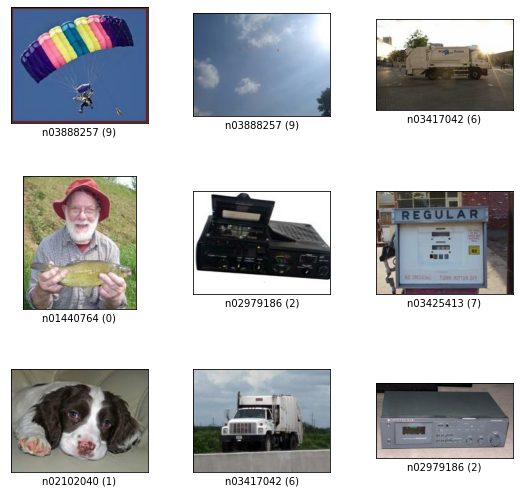

In [23]:
datasets, datasets_info = tfds.load('imagenette/160px-v2', shuffle_files=True, as_supervised=True, with_info=True)
train_dataset, validation_dataset = datasets['train'], datasets['validation']
fig = tfds.show_examples(validation_dataset, datasets_info)

In [24]:
def preprocessing(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image - MEAN_RGB
    image = image / STDDEV_RGB
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


train_dataset = (train_dataset.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .batch(BATCH_SIZE)
                              .prefetch(tf.data.experimental.AUTOTUNE))

validation_dataset = (validation_dataset.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                        .batch(BATCH_SIZE)
                                        .prefetch(tf.data.experimental.AUTOTUNE))

## Define a Floating-Point Model

In [25]:
def residual_conv_block(filters, stage, block, strides=(1, 1), cut='pre'):
    def layer(input_tensor):
        x = layers.BatchNormalization(epsilon=2e-5)(input_tensor)
        x = layers.Activation('relu')(x)

        # defining shortcut connection
        if cut == 'pre':
            shortcut = input_tensor
        elif cut == 'post':
            shortcut = layers.Conv2D(filters, (1, 1), strides=strides, kernel_initializer='he_uniform', 
                                     use_bias=False)(x)

        # continue with convolution layers
        x = layers.ZeroPadding2D(padding=(1, 1))(x)
        x = layers.Conv2D(filters, (3, 3), strides=strides, kernel_initializer='he_uniform', use_bias=False)(x)

        x = layers.BatchNormalization(epsilon=2e-5)(x)
        x = layers.Activation('relu')(x)
        x = layers.ZeroPadding2D(padding=(1, 1))(x)
        x = layers.Conv2D(filters, (3, 3), kernel_initializer='he_uniform', use_bias=False)(x)

        # add residual connection
        x = layers.Add()([x, shortcut])
        return x

    return layer


def ResNet18(input_shape=None):
    """Instantiates the ResNet18 architecture."""
    img_input = layers.Input(shape=input_shape, name='data')

    # ResNet18 bottom
    x = layers.BatchNormalization(epsilon=2e-5, scale=False)(img_input)
    x = layers.ZeroPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_uniform', use_bias=False)(x)
    x = layers.BatchNormalization(epsilon=2e-5)(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(x)

    # ResNet18 body
    repetitions = (2, 2, 2, 2)
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            filters = 64 * (2 ** stage)
            if block == 0 and stage == 0:
                x = residual_conv_block(filters, stage, block, strides=(1, 1), cut='post')(x)
            elif block == 0:
                x = residual_conv_block(filters, stage, block, strides=(2, 2), cut='post')(x)
            else:
                x = residual_conv_block(filters, stage, block, strides=(1, 1), cut='pre')(x)
    x = layers.BatchNormalization(epsilon=2e-5)(x)
    x = layers.Activation('relu')(x)

    # ResNet18 top
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(NUM_CLASSES)(x)
    x = layers.Activation('softmax')(x)

    # Create model
    model = models.Model(img_input, x)

    return model

In [26]:
IMG_SHAPE = IMG_SIZE + (3,)
model = ResNet18(input_shape=IMG_SHAPE)

## Pre-train Floating-Point Model

Using NNCF for model compression assumes that the user has a pre-trained model and a training pipeline.

> **NOTE** For the sake of simplicity of the tutorial, we propose to skip FP32 model training and load the weights that are provided.

In [6]:
# Load the floating-point weights
model.load_weights(fp32_h5_path)

# Compile the floating-point model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc@1')])

# Validate the floating-point model
test_loss, test_acc = model.evaluate(validation_dataset,
                                     callbacks=tf.keras.callbacks.ProgbarLogger(stateful_metrics=['acc@1']))
print(f"\nAccuracy of FP32 model: {test_acc:.3f}")

31/31 [==============================] - 8s 258ms/sample - loss: 0.7793 - acc@1: 0.8935

Accuracy of FP32 model: 0.894


Save the floating-point model to the saved model, which will be later used for conversion to OpenVINO IR and further performance measurement.

In [7]:
model.save(fp32_sm_path)
print(f'Absolute path where the model is saved:\n {fp32_sm_path.resolve()}')

2022-03-23 16:01:47.299068: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: output/ResNet-18_fp32/assets


INFO:tensorflow:Assets written to: output/ResNet-18_fp32/assets


Absolute path where the model is saved:
 /home/junwenwu/compression_demo/305-tensorflow-quantization-aware-training/output/ResNet-18_fp32


## Create and Initialize Quantization

NNCF enables compression-aware training by integrating into regular training pipelines. The framework is designed so that modifications to your original training code are minor. Quantization is the simplest scenario and requires only 3 modifications.

1. Configure NNCF parameters to specify compression

In [8]:
nncf_config_dict = {
    "input_info": {"sample_size": [1, 3] + list(IMG_SIZE)},
    "log_dir": str(OUTPUT_DIR),  # log directory for NNCF-specific logging outputs
    
    "compression": [
       {
            "algorithm": "filter_pruning",
            "pruning_init": 0.2,
            "params": {
                "schedule": "exponential",
                "pruning_target": 0.3,
                "filter_importance": "geometric_median"
            }
       },
       {
        "algorithm": "quantization",
       }
    ]
}
nncf_config = NNCFConfig.from_dict(nncf_config_dict)

2. Provide data loader to initialize the values of quantization ranges and determine which activation should be signed or unsigned from the collected statistics using a given number of samples.

In [9]:
nncf_config = register_default_init_args(nncf_config=nncf_config,
                                         data_loader=train_dataset,
                                         batch_size=BATCH_SIZE)

3. Create a wrapped model ready for compression fine-tuning from a pre-trained FP32 model and configuration object.

In [10]:
compression_ctrl, model = create_compressed_model(model, nncf_config)

2022-03-23 16:02:09.885456: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-03-23 16:02:10.514286: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-03-23 16:02:20.078832: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In 

Evaluate the new model on the validation set after initialization of quantization. The accuracy should be not far from the accuracy of the floating-point FP32 model for a simple case like the one we are demonstrating now.

In [11]:
# Compile the int8 model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc@1')])

# Validate the int8 model
test_loss, test_acc = model.evaluate(validation_dataset,
                                     callbacks=tf.keras.callbacks.ProgbarLogger(stateful_metrics=['acc@1']))
print(f"\nAccuracy of INT8 model after initialization: {test_acc:.3f}")

31/31 [==============================] - 8s 257ms/sample - loss: 1.9058 - acc@1: 0.4471

Accuracy of INT8 model after initialization: 0.447


## Fine-tune the Compressed Model

At this step, a regular fine-tuning process is applied to restore accuracy drop. Normally, several epochs of tuning are required with a small learning rate, the same that is usually used at the end of the training of the original model. No other changes in the training pipeline are required. Here is a simple example.

In [12]:
# Train the int8 model
model.fit(train_dataset,
          epochs=2)

# Validate the int8 model
test_loss, test_acc = model.evaluate(validation_dataset,
                                     callbacks=tf.keras.callbacks.ProgbarLogger(stateful_metrics=['acc@1']))
print(f"\nAccuracy of INT8 model after fine-tuning: {test_acc:.3f}")

Epoch 1/2
74/74 [==============================] - 93s 1s/step - loss: 0.9503 - acc@1: 0.8124
Epoch 2/2
31/31 [==============================] - 5s 153ms/sample - loss: 0.8974 - acc@1: 0.8359

Accuracy of INT8 model after fine-tuning: 0.836


Save the INT8 model to the frozen graph (saved model does not work with quantized model for now). Frozen graph will be later used for conversion to OpenVINO IR and further performance measurement.

In [13]:
compression_ctrl.export_model(int8_pb_path, 'frozen_graph')
print(f'Absolute path where the int8 model is saved:\n {int8_pb_path.resolve()}')

2022-03-23 16:06:59.996062: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2022-03-23 16:06:59.996269: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-03-23 16:06:59.997135: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-23 16:07:00.040200: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.006ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.



Absolute path where the int8 model is saved:
 /home/junwenwu/compression_demo/305-tensorflow-quantization-aware-training/output/ResNet-18_int8_pruned.pb


## Export Frozen Graph Models to OpenVINO™ Intermediate Representation (IR)

Call the OpenVINO Model Optimizer tool to convert the Saved Model and Frozen Graph models to OpenVINO IR. The models are saved to the current directory.

See the [Model Optimizer Developer Guide](https://docs.openvinotoolkit.org/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) for more information about Model Optimizer.

Executing this command may take a while. There may be some errors or warnings in the output. Model Optimization successfully export to IR if the last lines of the output include: `[ SUCCESS ] Generated IR version 10 model`

In [3]:
!mo --framework=tf --input_shape=[1,64,64,3] --input=data --saved_model_dir=$fp32_sm_path --output_dir=$OUTPUT_DIR

[ WARNING ] Telemetry will not be sent as TID is not specified.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/home/junwenwu/compression_demo/305-tensorflow-quantization-aware-training/output
	- IR output name: 	saved_model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	data
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,64,64,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- Update the configuration file with input/output nod

In [4]:
!mo --framework=tf --input_shape=[1,64,64,3] --input=Placeholder --input_model=$int8_pb_path --output_dir=$OUTPUT_DIR

[ WARNING ] Telemetry will not be sent as TID is not specified.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/junwenwu/compression_demo/305-tensorflow-quantization-aware-training/output/ResNet-18_int8_pruned.pb
	- Path for generated IR: 	/home/junwenwu/compression_demo/305-tensorflow-quantization-aware-training/output
	- IR output name: 	ResNet-18_int8_pruned
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Placeholder
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,64,64,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shar

## Benchmark Model Performance by Computing Inference Time

Finally, we will measure the inference performance of the FP32 and INT8 models. To do this, we use [Benchmark Tool](https://docs.openvinotoolkit.org/latest/openvino_inference_engine_tools_benchmark_tool_README.html) - OpenVINO's inference performance measurement tool. By default, Benchmark Tool runs inference for 60 seconds in asynchronous mode on CPU. It returns inference speed as latency (milliseconds per image) and throughput (frames per second) values.

> **NOTE**: In this notebook we run benchmark_app for 15 seconds to give a quick indication of performance. For more accurate performance, we recommended running benchmark_app in a terminal/command prompt after closing other applications. Run benchmark_app -m model.xml -d CPU to benchmark async inference on CPU for one minute. Change CPU to GPU to benchmark on GPU. Run benchmark_app --help to see an overview of all command line options.

In [5]:
def parse_benchmark_output(benchmark_output):
    parsed_output = [line for line in benchmark_output if not (line.startswith(r"[") or line.startswith("  ") or line == "")]
    print(*parsed_output, sep='\n')


print('Benchmark FP32 model (IR)')
benchmark_output = ! benchmark_app -m $fp32_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

print('\nBenchmark INT8 model (IR)')
benchmark_output = ! benchmark_app -m $int8_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

Benchmark FP32 model (IR)
Count:      96824 iterations
Duration:   15003.50 ms
Latency:    2.05 ms
Throughput: 6453.43 FPS

Benchmark INT8 model (IR)
Count:      349090 iterations
Duration:   15001.09 ms
Latency:    0.49 ms
Throughput: 23270.98 FPS


Show CPU Information for reference

In [6]:
from openvino.inference_engine import IECore

ie = IECore()
ie.get_metric(device_name='CPU', metric_name="FULL_DEVICE_NAME")

'Intel(R) Xeon(R) Gold 6348 CPU @ 2.60GHz'

POT quantization

In [7]:
import os
import copy
import cv2
import numpy as np
from addict import Dict
from compression.api import DataLoader, Metric
from compression.engines.ie_engine import IEEngine
from compression.graph import load_model, save_model
from compression.graph.model_utils import compress_model_weights
from compression.pipeline.initializer import create_pipeline
from openvino.inference_engine import IECore
from pathlib import Path
from PIL import Image

16:21:33 accuracy_checker WARNING: /home/junwenwu/anaconda3/envs/venv_demo/lib/python3.7/site-packages/defusedxml/__init__.py:30: DeprecationWarning: defusedxml.cElementTree is deprecated, import from defusedxml.ElementTree instead.
  from . import cElementTree

16:21:33 accuracy_checker WARNING: /home/junwenwu/anaconda3/envs/venv_demo/lib/python3.7/site-packages/compression/algorithms/quantization/optimization/algorithm.py:30: UserWarning: Nevergrad package could not be imported. If you are planning to useany hyperparameter optimization algo, consider installing itusing pip. This implies advanced usage of the tool.Note that nevergrad is compatible only with Python 3.6+
  'Nevergrad package could not be imported. If you are planning to use'



[ WARNING ] Telemetry will not be sent as TID is not specified.


In [27]:

model_config = Dict(
    {
        "model_name": "ResNet-18",
        "model": "output/saved_model.xml",
        "weights": "output/saved_model.bin",
    }
)

qat_model_config = Dict(
    {
        "model_name": "ResNet-18",
        "model": "output/ResNet-18_int8.xml",
        "weights": "output/ResNet-18_int8.bin",
    }
)

qat_pruned_model_config = Dict(
    {
        "model_name": "ResNet-18",
        "model": "output/ResNet-18_int8_pruned.xml",
        "weights": "output/ResNet-18_int8_pruned.bin",
    }
)

engine_config = Dict({"device": "CPU", "stat_requests_number": 2, "eval_requests_number": 2})

algorithms = [
    {
        "name": "DefaultQuantization",
        "params": {
            "target_device": "CPU",
            "preset": "performance",
            "stat_subset_size": 200,
        },
    }
]

In [28]:
class ClassificationDataLoader(DataLoader):
    """
    DataLoader for image data that is stored in a directory per category. For example, for
    categories _rose_ and _daisy_, rose images are expected in data_source/rose, daisy images
    in data_source/daisy.
    """

    def __init__(self, data_source):
        """
        :param data_source: path to data directory
        """
        self.data_source = Path(data_source)
        self.dataset = [p for p in data_dir.glob("**/*") if p.suffix in (".png", ".JPEG")]
        self.class_names = sorted([item.name for item in Path(data_dir).iterdir() if item.is_dir()])
        print("Data Loader")
        print(self.class_names)

    def __len__(self):
        """
        Returns the number of elements in the dataset
        """
        #print(len(self.dataset))
        #return len(self.dataset[0:100])
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Get item from self.dataset at the specified index.
        Returns (annotation, image), where annotation is a tuple (index, class_index)
        and image a preprocessed image in network shape
        """
        if index >= len(self):
            raise IndexError
        filepath = self.dataset[index]
        annotation = (index, self.class_names.index(filepath.parent.name))
        #print(annotation)
        image = self._read_image(filepath)

        return annotation, image

    def _read_image(self, index):
        """
        Read image at dataset[index] to memory, resize, convert to BGR and to network shape

        :param index: dataset index to read
        :return ndarray representation of image batch
        """
        #image = cv2.imread(os.path.join(self.data_source, index))[:, :, (2, 1, 0)]
        image = cv2.imread(os.path.abspath(index))[:, :, (2, 1, 0)]
        image = cv2.resize(image, (64, 64)).astype(np.float32)  
        MEAN_RGB = (0.485 * 255, 0.456 * 255, 0.406 * 255)  # From Imagenet dataset
        STDDEV_RGB = (0.229 * 255, 0.224 * 255, 0.225 * 255)  # From Imagenet dataset
        image = image - MEAN_RGB
        image = image / STDDEV_RGB
      
        return image.transpose(2, 0, 1)

In [29]:
class Accuracy(Metric):
    def __init__(self):
        super().__init__()
        self._name = "accuracy"
        self._matches = []

    @property
    def value(self):
        """Returns accuracy metric value for the last model output."""
        return {self._name: self._matches[-1]}

    @property
    def avg_value(self):
        """
        Returns accuracy metric value for all model outputs. Results per image are stored in
        self._matches, where True means a correct prediction and False a wrong prediction.
        Accuracy is computed as the number of correct predictions divided by the total
        number of predictions.
        """
        num_correct = np.count_nonzero(self._matches)
        return {self._name: num_correct / len(self._matches)}

    def update(self, output, target):
        """Updates prediction matches.

        :param output: model output
        :param target: annotations
        """
        predict = np.argmax(output[0], axis=1)
        #print(f'Prediction:{predict} Target:{target}')
        match = predict == target
        self._matches.append(match)

    def reset(self):
        """
        Resets the Accuracy metric. This is a required method that should initialize all
        attributes to their initial value.
        """
        self._matches = []

    def get_attributes(self):
        """
        Returns a dictionary of metric attributes {metric_name: {attribute_name: value}}.
        Required attributes: 'direction': 'higher-better' or 'higher-worse'
                             'type': metric type
        """
        return {self._name: {"direction": "higher-better", "type": "accuracy"}}

In [31]:
# Step 1: Load the model
model = load_model(model_config=model_config)
original_model = copy.deepcopy(model)

qat_model = load_model(model_config=qat_model_config)
qat_pruned_model = load_model(model_config=qat_pruned_model_config)

data_dir = Path('dataset/imagenette2-160/val')

# Step 2: Initialize the data loader
data_loader = ClassificationDataLoader(data_source=data_dir)

# Step 3 (Optional. Required for AccuracyAwareQuantization): Initialize the metric
#        Compute metric results on original model
metric = Accuracy()

# Step 4: Initialize the engine for metric calculation and statistics collection
engine = IEEngine(config=engine_config, data_loader=data_loader, metric=metric)

# Step 5: Create a pipeline of compression algorithms
pipeline = create_pipeline(algo_config=algorithms, engine=engine)

# Step 6 (Optional): Evaluate the original model. Print the results
metric_results_FP32  = pipeline.evaluate(model=model)
if metric_results_FP32 :
    print("FP32 model results:")
    for name, value in metric_results_FP32 .items():
        print(f"{name}: {value:.5f}")

# Step 6: Execute the pipeline
compressed_model = pipeline.run(model=model)

# Step 9 (Optional): Evaluate the compressed model. Print the results.
metric_results_INT8_POT = pipeline.evaluate(compressed_model)
if metric_results_INT8_POT :
    print("INT8 optimized model (with POT) results:")
    for name, value in metric_results_INT8_POT .items():
        print(f"{name}: {value:.5f}")

# Step 9 (Optional): Evaluate the NNCF compressed model. Print the results.
metric_results_INT8_QAT = pipeline.evaluate(qat_model)
if metric_results_INT8_QAT :
    print("INT8 optimized model (with QAT) results:")
    for name, value in metric_results_INT8_QAT .items():
        print(f"{name}: {value:.5f}")

# Step 9 (Optional): Evaluate the NNCF compressed model. Print the results.
metric_results_INT8_QAT_PRUNED = pipeline.evaluate(qat_pruned_model)
if metric_results_INT8_QAT_PRUNED :
    print("INT8 optimized model (with QAT + FilterPruning) results:")
    for name, value in metric_results_INT8_QAT_PRUNED .items():
        print(f"{name}: {value:.5f}")

# Step 7 (Optional): Compress model weights quantized precision
#                    in order to reduce the size of final .bin file
compress_model_weights(model=compressed_model)

# Step 8: Save the compressed model and get the path to the model
compressed_model_paths = save_model(
    model=compressed_model, save_path=os.path.join(os.path.curdir, "model/optimized")
)
compressed_model_xml = Path(compressed_model_paths[0]["model"])
print(f"The quantized model is stored in {compressed_model_xml}")



Data Loader
['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']
FP32 model results:
accuracy: 0.89274
INT8 optimized model (with POT) results:
accuracy: 0.89172
INT8 optimized model (with QAT) results:
accuracy: 0.91541
INT8 optimized model (with QAT + FilterPruning) results:
accuracy: 0.12841
The quantized model is stored in model/optimized/saved_model.xml


In [32]:
def parse_benchmark_output(benchmark_output):
    parsed_output = [line for line in benchmark_output if not (line.startswith(r"[") or line.startswith("  ") or line == "")]
    print(*parsed_output, sep='\n')

fp32_ir_path = Path("output/saved_model").with_suffix(".xml")
int8_pot_ir_path = Path("model/optimized/saved_model").with_suffix(".xml")
int8_qat_ir_path = Path("output/ResNet-18_int8").with_suffix(".xml")
int8_qat_pruned_ir_path = Path("output/ResNet-18_int8_pruned").with_suffix(".xml")

print('Benchmark FP32 model (IR)')
benchmark_output = ! benchmark_app -m $fp32_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

print('\nBenchmark INT8 optimized (with POT) model (IR)')
benchmark_output = ! benchmark_app -m $int8_pot_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

print('\nBenchmark INT8 optimized (with QAT) model (IR)')
benchmark_output = ! benchmark_app -m $int8_qat_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

print('\nBenchmark INT8 optimized (with QAT + FilterPruning) model (IR)')
benchmark_output = ! benchmark_app -m $int8_qat_pruned_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

Benchmark FP32 model (IR)
Count:      99722 iterations
Duration:   15002.55 ms
Latency:    1.99 ms
Throughput: 6647.01 FPS

Benchmark INT8 optimized (with POT) model (IR)
Count:      326144 iterations
Duration:   15000.63 ms
Latency:    0.48 ms
Throughput: 21742.01 FPS

Benchmark INT8 optimized (with QAT) model (IR)
Count:      356832 iterations
Duration:   15001.01 ms
Latency:    0.47 ms
Throughput: 23787.20 FPS

Benchmark INT8 optimized (with QAT + FilterPruning) model (IR)
Count:      375018 iterations
Duration:   15000.90 ms
Latency:    0.46 ms
Throughput: 24999.71 FPS
